In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 1. Load Data

In [2]:
city_search = pd.read_json('/Users/ChunyanHao/desktop/github/ds_take_home/data/city_search.json')
city_search.head(3)

,session_id,unix_timestamp,cities,user
0,[X061RFWB06K9V],[1442503708],"[New York NY, Newark NJ]","[[{'user_id': 2024, 'joining_date': '2015-03-2..."
1,[5AZ2X2A9BHH5U],[1441353991],"[New York NY, Jersey City NJ, Philadelphia PA]","[[{'user_id': 2853, 'joining_date': '2015-03-2..."
2,[SHTB4IYAX4PX6],[1440843490],[San Antonio TX],"[[{'user_id': 10958, 'joining_date': '2015-03-..."


Create a new DataFrame after splitting cities and user's basic information

In [3]:
def parse_json(data):
    """create a list for each column"""
    session_id = []
    unix_timestamp = []
    cities = []
    user_id = []
    joining_date = []
    country = []
    
    for i in range(len(data)):
        row = data.iloc[i, :]
        session_id.append(row['session_id'][0])
        unix_timestamp.append(row['unix_timestamp'][0])
        cities.append(row['cities'][0])
        user_id.append(row['user'][0][0]['user_id'])
        joining_date.append(row['user'][0][0]['joining_date'])
        country.append(row['user'][0][0]['country'])
    dict = {'session_id': session_id, 'unix_timestamp': unix_timestamp, 'cities': cities,
            'user_id': user_id, 'joining_date': joining_date, 'country': country}  
    df = pd.DataFrame(dict) 
    return df

In [4]:
city_search = parse_json(city_search)

In [5]:
city_search.head(3)

,session_id,unix_timestamp,cities,user_id,joining_date,country
0,X061RFWB06K9V,1442503708,"New York NY, Newark NJ",2024,2015-03-22,UK
1,5AZ2X2A9BHH5U,1441353991,"New York NY, Jersey City NJ, Philadelphia PA",2853,2015-03-28,DE
2,SHTB4IYAX4PX6,1440843490,San Antonio TX,10958,2015-03-06,UK


In [6]:
city_search['joining_date'] = pd.to_datetime(city_search['joining_date'])
city_search['datetime'] = pd.to_datetime(city_search['unix_timestamp'], unit='s')
city_search['date'] = city_search['datetime'].dt.date
# city_search['year'] = city_search['datetime'].dt.year
# city_search['month'] = city_search['datetime'].dt.month
# city_search['day'] = city_search['datetime'].dt.day
# city_search['weekday'] = city_search['datetime'].dt.weekday
city_search['hour'] = city_search['datetime'].dt.hour

In [7]:
city_search.head(1)

,session_id,unix_timestamp,cities,user_id,joining_date,country,datetime,date,hour
0,X061RFWB06K9V,1442503708,"New York NY, Newark NJ",2024,2015-03-22,UK,2015-09-17 15:28:28,2015-09-17,15


In [8]:
# improve level of normalization, split the 'cities' columns into multiple rows:

city_search['cities'] = city_search['cities'].apply(lambda x: x.split(', '))

data = city_search.copy()
rows = []
_ = data.apply(lambda row: [rows.append(
    [row['session_id'], row['date'], row['hour'], city, row['user_id'], row['joining_date'],   row['country']]) 
                         for city in row.cities], axis=1)
data = pd.DataFrame(rows)

data.columns = ['session_id', 'date', 'hour', 'city', 'user_id', 'joining_date','country']
data.head(5)

,session_id,date,hour,city,user_id,joining_date,country
0,X061RFWB06K9V,2015-09-17,15,New York NY,2024,2015-03-22,UK
1,X061RFWB06K9V,2015-09-17,15,Newark NJ,2024,2015-03-22,UK
2,5AZ2X2A9BHH5U,2015-09-04,8,New York NY,2853,2015-03-28,DE
3,5AZ2X2A9BHH5U,2015-09-04,8,Jersey City NJ,2853,2015-03-28,DE
4,5AZ2X2A9BHH5U,2015-09-04,8,Philadelphia PA,2853,2015-03-28,DE


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33016 entries, 0 to 33015
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   session_id    33016 non-null  object        
 1   date          33016 non-null  object        
 2   hour          33016 non-null  int64         
 3   city          33016 non-null  object        
 4   user_id       33016 non-null  int64         
 5   joining_date  33016 non-null  datetime64[ns]
 6   country       33016 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 1.8+ MB


## 2. Question 1

There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?

In [10]:
data.groupby(['country'])['country'].count()

country
      4619
DE    6003
ES    3202
FR    3767
IT    3132
UK    5907
US    6386
Name: country, dtype: int64

In [11]:
data.loc[data.country == '','country'] = 'Missing'

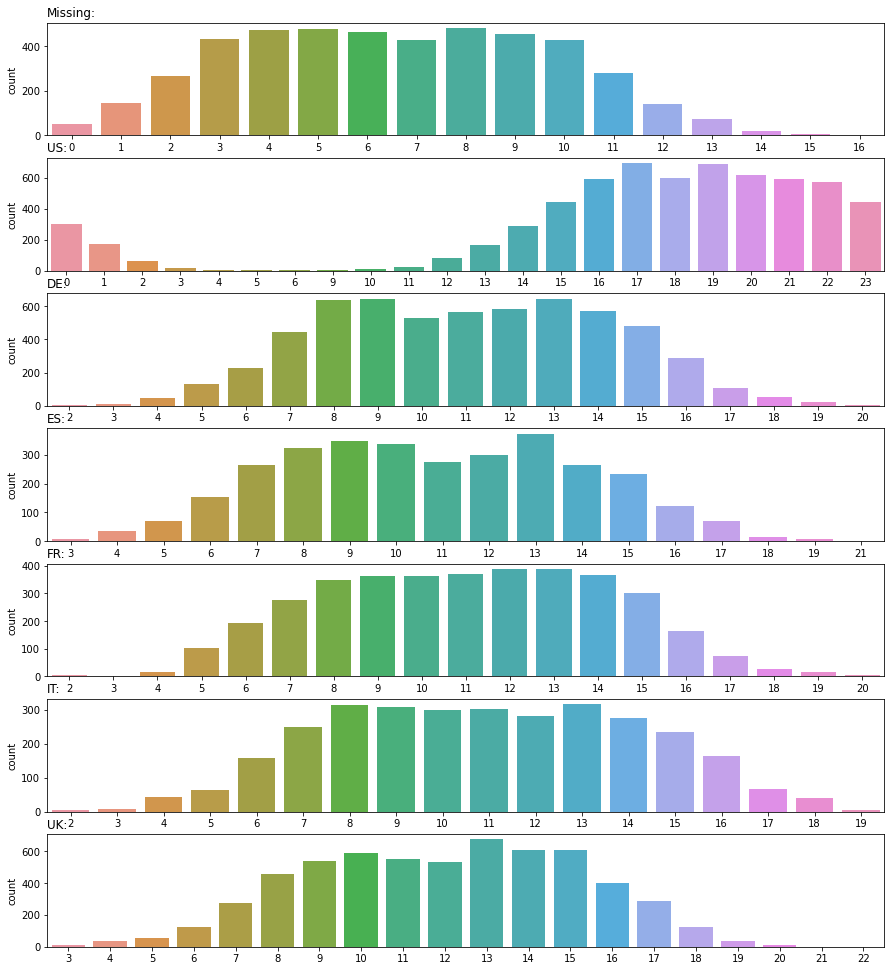

In [12]:
fig, ax = plt.subplots(7, 1, figsize = (15, 17))
countries = ['Missing', 'US', 'DE', 'ES', 'FR', 'IT', 'UK']
for i in range(len(countries)):
    sns.countplot(data = data[data.country == countries[i]],x = 'hour', ax = ax[i])
    ax[i].set_xlabel( "" , size = 12 )
    ax[i].set_title( countries[i] + ':', size = 12, loc = 'left')

from above plot, we can see that, "the searching time" habit of the "Missing" and US are very different from 'UK','DE', 'ES', 'FR', 'IT'. so 'Missing' country, like US, cannot be in Europe.

Also from the plots above, the Missing country has a time difference about 11~12 hours with US.

Based on above two facts, he Missing country should be in Asia, and it must have good economic to allow people to travel aboard. Hence, I guess the Missing country may be China, Japan or South Korean.

## Question 2

For each city, find the most likely city to be also searched for within the same session.

We can solve this problem use a similar method as K-means. 

To specify:

1) create a vector for each city, the i-th value in this vector represents if the # i-th session searched this city or not.

2) calculate cosine similarity between any two city vectors, get a similarity matrix. Similarity[i,j] represents the similarity between i-th and j-th city

3) get the top similar cities with i-th city

In [13]:
from sklearn.preprocessing import normalize

In [14]:
# 1) create a vector for each city

pre_pivot = data[['session_id', 'city', 'user_id']].groupby(['session_id', 'city'])['user_id'].count().reset_index(name = 'count')
pivot_df = pre_pivot.pivot_table(index = 'city', columns = 'session_id', values = 'count').fillna(0)
pivot_df.head(3)

session_id,0004TZ56GY6S7,004M08GLQ7ZXH,007O320DQ7AXT,007UIISVZJOW5,008ZL2D1PLC4O,00C8JBREV4NBU,00FBBMQ9RPM9N,00H99K6WLXUXI,00KLXTMMVX344,00KN4XQGM6PU2,...,ZZHH6F36K60I8,ZZIG141UBHAU0,ZZJ94ORDE8A2X,ZZLVF0OPBUQ5I,ZZMJ49EKR9FB9,ZZS8OMNGVGEGV,ZZV3W3ZE2R0W8,ZZWVLD5228M5Z,ZZWX86DF4JBLT,ZZZGT1H4I13GM
city,,,,,,,,,,,,,,,,,,,,,
Anaheim CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arlington TX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Atlanta GA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# 2) calculate cosine similarity between any two city vectors

pivot_df_normed = normalize(pivot_df,axis=1)
city_similarity = pivot_df_normed.dot(pivot_df_normed.T)
city_similarity = pd.DataFrame(city_similarity, 
                               index = pivot_df.index, columns = pivot_df.index)
city_similarity.head(3)

city,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
city,,,,,,,,,,,,,,,,,,,,,
Anaheim CA,1.0,0.0,0.0,0.000000,0.019636,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Arlington TX,0.0,1.0,0.0,0.207325,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.113455,0.0,0.0,0.0,0.0,0.0,0.0
Atlanta GA,0.0,0.0,1.0,0.000000,0.000000,0.0,0.494872,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# 3) get the top similar cities with i-th city
city_names = city_similarity.columns
ans = []
similarity = []
for i in range(len(city_similarity)):
    row = city_similarity.iloc[i, :]
    row[i] = 0
    for j in range(len(city_similarity)):
        if row[j] == max(row):
            ans.append(city_names[j])
            similarity.append(row[j])
            break
results = pd.DataFrame({'city': city_names, 
                        'most_similar_city': ans, 
                        'similarity':similarity}).sort_values(by = 'similarity', ascending = False)

In [18]:
# Sort the result based on search popularity
city_popularity_sort = data.groupby(['city'])['session_id'].count().reset_index(name = 'search_times')
city_popularity_sort = city_popularity_sort.sort_values(by = 'search_times', ascending = False)
city_popularity_sort['rank'] = city_popularity_sort['search_times'].rank(method = 'first', ascending = False)
results = pd.merge(left = results, right = city_popularity_sort, on = 'city')
results = results.sort_values(by = 'rank').reset_index().iloc[:,1:-1]
results.head(6)

,city,most_similar_city,similarity,search_times
0,New York NY,Jersey City NJ,0.303339,5361
1,Toronto ON,Saint Catharines-Niagara ON,0.266551,3279
2,Los Angeles CA,Long Beach CA,0.288009,2672
3,Montreal QC,OTTAWA ON,0.208128,2336
4,Chicago IL,Milwaukee WI,0.302424,1979
5,Houston TX,Austin TX,0.274307,1394


## 4 Question 3

Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

For this question, one way is to actually calculate the geographic distance for actual searched cities. However, this solution is not very practical for this small project. Another choice is to calculate the distance based on the city-city similarity in Question 2.

To specify:

1) for each search column(each session_id) retrieve the distance for each city pair and calculate the average distance for each session

2) cluster all sessions into two groups

In [19]:
def avg_distance(city_list):
    if len(city_list) == 1:
        return 0
    total_distance = 0
    count = 0
    for i in range(1, len(city_list)):
        for j in range(i):
            total_distance += (1 - (city_similarity.loc[city_list[i], city_list[j]]))
            count += 1
    return total_distance/count

In [20]:
city_search['distance'] = city_search['cities'].apply(lambda x: avg_distance(x))

In [21]:
city_search['city_count'] = city_search['cities'].apply(lambda x: len(x))

<AxesSubplot:xlabel='city_count', ylabel='Count'>

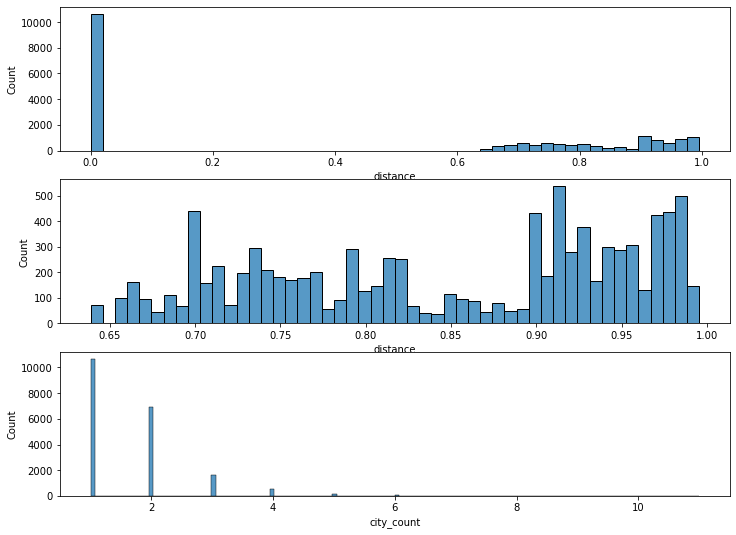

In [22]:
fig, ax = plt.subplots(3, 1, figsize = (12, 9))
sns.histplot(data = city_search, x = 'distance', bins = 50, ax = ax[0])
sns.histplot(data = city_search[city_search.city_count > 1], x = 'distance', bins = 50, ax = ax[1])

sns.histplot(data = city_search, x = 'city_count', ax = ax[2])

In [23]:
100*city_search.groupby(['city_count'])['session_id'].count()/len(city_search)

city_count
1     53.296374
2     34.492059
3      8.086105
4      2.826890
5      0.889022
6      0.304665
7      0.079912
8      0.014984
9      0.004995
11     0.004995
Name: session_id, dtype: float64

It seems that more than 50% of the search sessions are with only one city, therefore the distance is 0. For those search sessions with more than 1 cities, we can set the threshold as 0.9 for example and label then as two groups. 